In [1]:
import json
import logging
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy import interpolate

C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Futu

In [2]:
from config import get_config
from equation import get_equation
from solver import FeedForwardModel

In [3]:
s0=100
k=100
r=0.00
sigma=0.20
T=1

d1=(np.log(s0/k)+(r+sigma*sigma/2)*T)/(sigma*np.sqrt(T))
d2=(np.log(s0/k)+(r-sigma*sigma/2)*T)/(sigma*np.sqrt(T))

print(norm.cdf(d1)*s0-norm.cdf(d2)*k*np.exp(-r*T))

7.965567455405804


In [4]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)

del_all_flags(tf.app.flags.FLAGS)

FLAGS = tf.app.flags.FLAGS
tf.app.flags.DEFINE_string('f', '', 'kernel')

tf.app.flags.DEFINE_string('problem_name', 'EuropeanCall',
                           """The name of partial differential equation.""")
tf.app.flags.DEFINE_integer('num_run', 1,
                            """The number of experiments to repeatedly run for the same problem.""")
tf.app.flags.DEFINE_string('log_dir', './logs',
                           """Directory where to write event logs and output array.""")

In [5]:
weight_list=[]
problem_name = FLAGS.problem_name
config = get_config(problem_name)
bsde = get_equation(problem_name, config.dim, config.total_time, config.num_time_interval)

if not os.path.exists(FLAGS.log_dir):
    os.mkdir(FLAGS.log_dir)
path_prefix = os.path.join(FLAGS.log_dir, problem_name)
with open('{}_config.json'.format(path_prefix), 'w') as outfile:
    json.dump(dict((name, getattr(config, name))
                    for name in dir(config) if not name.startswith('__')),
                outfile, indent=2)
logging.basicConfig(level=logging.INFO,
                    format='%(levelname)-6s %(message)s')

for idx_run in range(1, FLAGS.num_run+1):
    tf.reset_default_graph()
    with tf.Session() as sess:
        logging.info('Begin to solve %s with run %d' % (problem_name, idx_run))
        model = FeedForwardModel(config, bsde, sess)
        if bsde.y_init:
            logging.info('Y0_true: %.4e' % bsde.y_init)
        model.build()
        training_history, graphs = model.train()
        for i in tf.trainable_variables():
            temp=i.name.split('/')
            #print(temp)
            if len(temp)>1:
                if temp[1]=='1':
                    weight_list.append(sess.run(i))
            #print(i.name)
            #print(sess.run(i))
            #print('\n')
        if bsde.y_init:
            logging.info('relative error of Y0: %s',
                            '{:.2%}'.format(
                                abs(bsde.y_init - training_history[-1, 2])/bsde.y_init))
        # save training history
        np.savetxt('{}_training_history_{}.csv'.format(path_prefix, idx_run),
                    training_history,
                    fmt=['%d', '%.5e', '%.5e', '%d'],
                    delimiter=",",
                    header="step,loss_function,target_value,elapsed_time",
                    comments='')

g=graphs

INFO   Begin to solve EuropeanCall with run 1


WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:58: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:61: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:76: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



t: 0
Instructions for updating:
keep_dims is deprecated, use keepdims instead


WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:83: calling reduce_sum_v1 (from tensorflow.python.ops.math_ops) with keep_dims is deprecated and will be removed in a future version.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:125: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:145: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



t: 1
t: 2
t: 3
t: 4
t: 5
t: 6
t: 7
t: 8



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:105: The name tf.train.piecewise_constant is deprecated. Please use tf.compat.v1.train.piecewise_constant instead.



WARNING From C:\Users\sy8w\OneDrive\Documents\Projects and Presentation\github\solver.py:110: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

INFO   step:     0,    loss: 1.4917e+02,   Y0: 5.6128e+00,  elapsed time  11
INFO   z_init: 3.8264e-02
INFO   step:    50,    loss: 1.4839e+02,   Y0: 5.8595e+00,  elapsed time  26
INFO   z_init: 1.9622e-01
INFO   step:   100,    loss: 1.4724e+02,   Y0: 6.0938e+00,  elapsed time  41
INFO   z_init: 1.8684e-01
INFO   step:   150,    loss: 1.4630e+02,   Y0: 6.3136e+00,  elapsed time  57
INFO   z_init: 1.8780e-01
INFO   step:   200,    loss: 1.4551e+02,   Y0: 6.5184e+00,  elapsed time  72
INFO   z_init: 1.8784e-01
INFO   step:   250,    loss: 1.4485e+02,   Y0: 6.7078e+00,  elapsed time  87
INFO   z_init: 1.8785e-01
INFO   step:   300,    loss: 1.4431e+02,   Y0: 6.8818e+00,  elapsed time 101
INFO   z_init: 1.8786e-01
INFO   step:   350,    loss: 1.4387e+02,   Y0: 7.0401e+00,  elapsed time 116
INFO   

In [6]:
def sigmoid(d):
    return 1/(1+np.exp(-d))

def relu(d):
    return np.maximum(d,0)

In [7]:
weight_list

[array([[ 1.05737462, -1.26116951,  2.16401008,  0.6598136 , -2.58728507,
          0.0991653 , -1.16955433,  2.50187861, -1.02160723,  0.50825095,
         -1.92261095]]),
 array([[ 0.4577948 , -0.00616504,  1.60967736,  1.5241551 , -0.20475368,
          0.88280559,  1.29033149,  1.27523743,  0.46289288, -2.21653775,
          0.98260403],
        [-0.30212639,  0.58488885,  0.25564434, -0.32218492, -0.65597841,
          0.58827189,  1.20683137, -0.23539981,  0.23741726, -0.56202514,
         -1.73004678],
        [ 0.7127962 ,  0.81412413, -1.44970994,  0.63062872,  1.61316697,
         -0.49103938, -0.95013617, -2.28787583,  1.2344189 ,  0.62084571,
          0.52393758],
        [ 3.16010119, -0.54803146,  1.38925443, -0.88731986, -0.68923837,
         -1.52235878,  2.33037315,  0.45668991, -1.35677043,  0.21835987,
         -0.18694693],
        [ 1.92189554,  0.09155713,  0.85311228, -0.01969854,  2.2642581 ,
         -1.06662586, -0.80573682,  1.05008989,  0.21758043, -1.69414

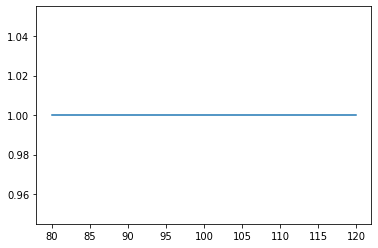

In [8]:
a=weight_list[0]
b=weight_list[1]
c=weight_list[2]
d=weight_list[3]
e=weight_list[4]

def layer(x):
    x=relu(a.dot(x).T)
    x=relu((b.T).dot(x))
    x=relu((c.T).dot(x))
    x=(d.T).dot(x)
    return sigmoid(x+e)

y=[layer(x) for x in np.linspace(80,120, 82)]
y=np.array(y).reshape(len(y),1)
fig, ax = plt.subplots()
ax.plot(np.linspace(80,120, 82),y)

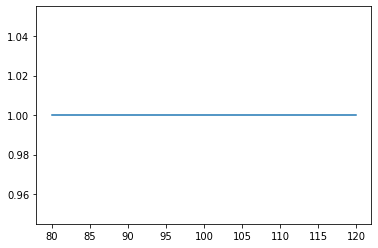

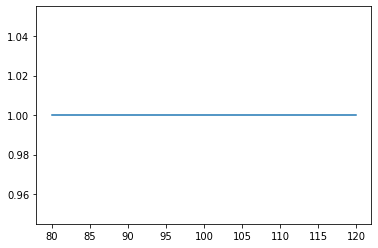

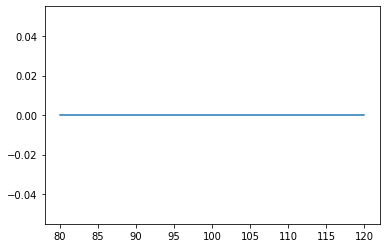

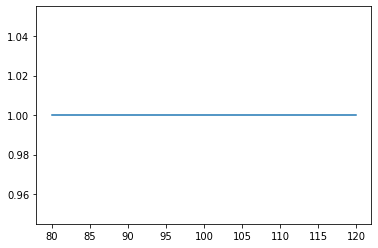

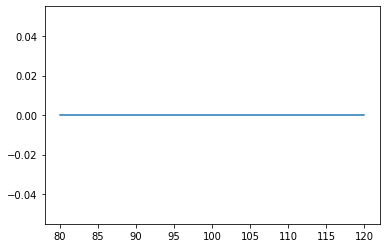

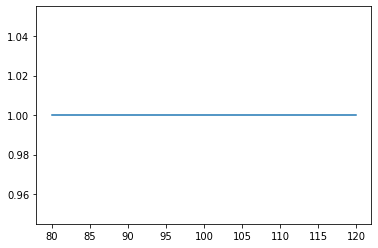

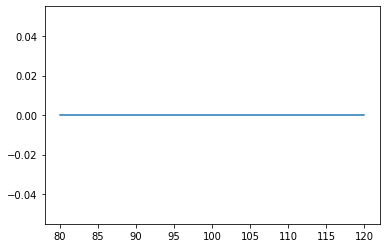

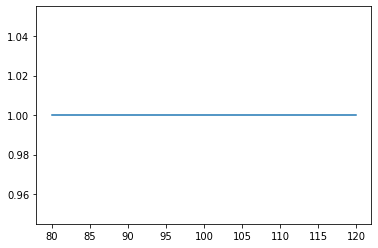

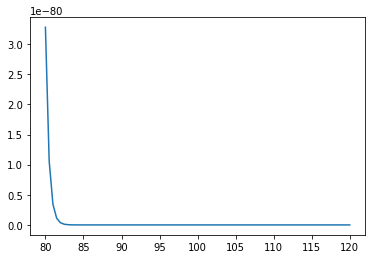

In [9]:
for i in range(len(g)):
    fig, ax = plt.subplots()
    ax.plot(np.linspace(80,120, 82),np.array(g[i]).flatten())